In [8]:
import numpy as np
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dense,MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tqdm import tqdm

2024-06-17 20:12:16.776382: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 20:12:16.813316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 20:12:17.317640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
# Verificar uso da GPU
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[]


2024-06-17 20:12:18.221401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-17 20:12:18.282329: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Dados de teste
dir = "./input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"] # Remover os caracteres não alfanuméricos
for i in tqdm (os.listdir(dir)):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1500: # limitador de arquivos
            break
            
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

100%|██████████| 39/39 [00:01<00:00, 35.63it/s]


In [11]:
len(train_data)

52500

In [12]:
# Dados de validação
val_dir = "./input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in tqdm(os.listdir(val_dir)):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 400: # limitador de arquivos
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

100%|██████████| 39/39 [00:00<00:00, 183.37it/s]


In [13]:
len(val_data)

10404

In [14]:
# Embaralha nossos valores de treino e teste, para evitar possível vicio na hora do treino
random.shuffle(train_data)
random.shuffle(val_data)

In [15]:
# Separação dos valores dentro do treino entre imagem e label (algo como, imagem e resposta)
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [16]:
# Repetindo a mesma ação anterior mas agora para valiadção
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [17]:
# Aqui a classe LabelBinarizer do sklearn irá transformar as labels (nome do caractere, como quiser chamar) 
# das imagens em um rótulo binário, para que possa ser usado realmente no momento que treinamos nossa rede,
# já que esses valores em string não podem ser usados.
# O LabelBinarizer também será fundamental para traduzirmos o resultado futuramente.
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)


In [18]:
train_X = np.array(train_X)/255.0 # Como os pixels variam de 0 à 255, ao dividir teremos apenas valores no intervalo de 0 a 1
train_X = train_X.reshape(-1,32,32,1) # Remodelamos o vetor para manter a dimensão original (-1) o tamanho de 32x32 e a imagem na escala cinza (1)
train_Y = np.array(train_Y) # Conversão para array numpy

In [19]:
# Mesma coisa citada acima mas com os valores de validação
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [20]:
print(train_X.shape,val_X.shape)

(52500, 32, 32, 1) (10404, 32, 32, 1)


In [21]:
print(train_Y.shape,val_Y.shape)

(52500, 35) (10404, 35)


In [22]:
model = Sequential() # Iniciamos nosso aprendizado de redes neurais sequenciais

# Primeira camada convolucional + pooling
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Segunda camada convolucional + pooling
model.add(Conv2D(64, (3, 3), activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Terceira camada convolucional + pooling
model.add(Conv2D(128, (3, 3), activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten "achata" a saída de vetor tridimensional das camadas convolucionais 
# e transforma em um vetor de uma dimensão só
model.add(Flatten())

# Graças ao Flattlen, agora é possível aplicar o Dense, que é responsável pela tomada de decisão final
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Finalmente, a ultima camada com o total de 35 neurônios, uma para cada classe possível de resultados (0 - 9 e A - Z) 
model.add(Dense(35, activation='softmax'))

In [23]:
model.summary() # Verificamos como tudo isso fica junto

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [24]:
# Compila
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [25]:
# E rodamos...
history = model.fit(train_X,train_Y, epochs=15, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/15
1641/1641 [==============================] - 20s 12ms/step - loss: 1.7427 - accuracy: 0.4980 - val_loss: 0.6556 - val_accuracy: 0.8020
Epoch 2/15
1641/1641 [==============================] - 21s 13ms/step - loss: 0.5502 - accuracy: 0.8207 - val_loss: 0.5098 - val_accuracy: 0.8402
Epoch 3/15
1641/1641 [==============================] - 21s 13ms/step - loss: 0.4393 - accuracy: 0.8536 - val_loss: 0.4623 - val_accuracy: 0.8460
Epoch 4/15
1641/1641 [==============================] - 21s 13ms/step - loss: 0.3844 - accuracy: 0.8717 - val_loss: 0.4155 - val_accuracy: 0.8635
Epoch 5/15
1641/1641 [==============================] - 20s 12ms/step - loss: 0.3490 - accuracy: 0.8816 - val_loss: 0.3796 - val_accuracy: 0.8763
Epoch 6/15
1641/1641 [==============================] - 20s 12ms/step - loss: 0.3205 - accuracy: 0.8908 - val_loss: 0.3852 - val_accuracy: 0.8674
Epoch 7/15
1641/1641 [==============================] - 21s 13ms/step - loss: 0.2991 - accuracy: 0.8973 - val_loss: 0.3655 -

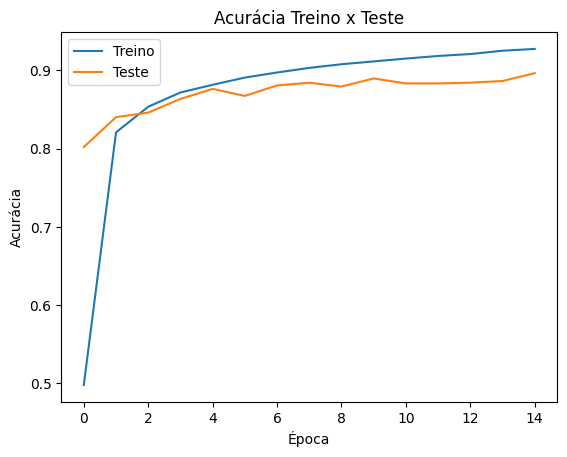

In [26]:
# Plotamos a precisão (acurácia) do treino comparado ao teste (validação)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia Treino x Teste')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

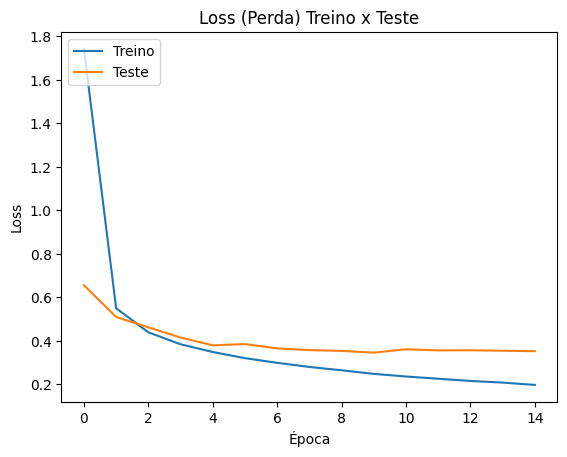

In [27]:
# Plotamos também a perda durante o treino e teste (validação)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss (Perda) Treino x Teste')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

In [28]:
# Pegamos o resultado geral

loss, accuracy = model.evaluate(train_X, train_Y)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

1641/1641 [==============================] - 8s 5ms/step - loss: 0.1470 - accuracy: 0.9444
Test loss: 0.14696288108825684
Test accuracy: 0.9444000124931335


In [29]:
# Essa função usa a lib cv2 (open-cv) para criar o contorno em volta de cada letra em uma palavra
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [30]:
# Esta função usa o open-cv também, mas agora junto com o nosso modelo para que então possa ser classificado
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

In [31]:
# Esta função junta todas as letras reconhecidas para formar a palavra
def get_word(letter):
    word = "".join(letter)
    return word

1/1 [==============================] - 0s 14ms/step
JPMEANW


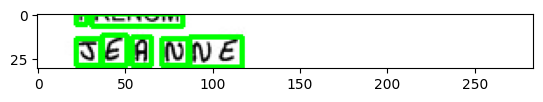

In [32]:
letter,image = get_letters("./input/handwriting-recognition/test_v2/test/TEST_0014.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 13ms/step
LIL0U


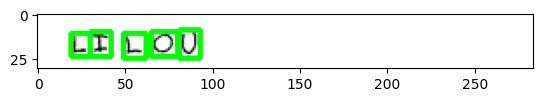

In [33]:
letter,image = get_letters("./input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 14ms/step
3AFFENX


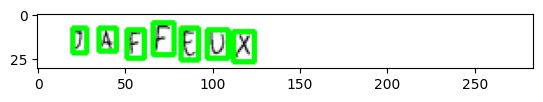

In [34]:
letter,image = get_letters("./input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 13ms/step
KUPP


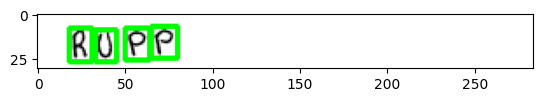

In [35]:
letter,image = get_letters("./input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 18ms/step
VALENTJNF


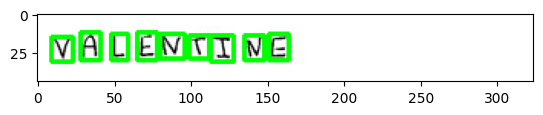

In [44]:
letter,image = get_letters("./input/handwriting-recognition/test_v2/test/TEST_0007.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 14ms/step
FWAEL


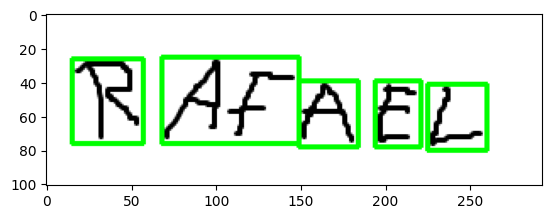

In [37]:
letter,image = get_letters("./test.png")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 13ms/step
YLK0D


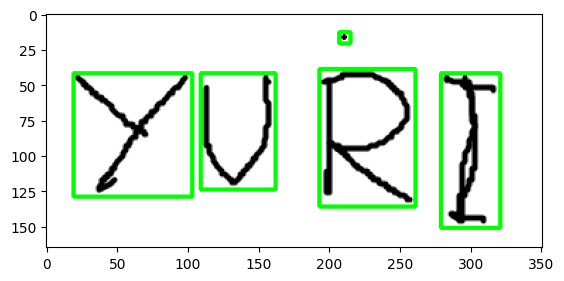

In [38]:
letter,image = get_letters("./test_02.png")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 21ms/step
YLLU


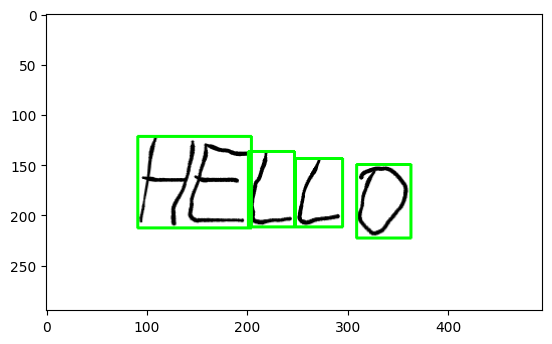

In [43]:
letter,image = get_letters("./test_03.png")
word = get_word(letter)
print(word)
plt.imshow(image)

In [40]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "./out_model")

/home/mitsogad/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
import joblib

model.save('./server/model.h5')
joblib.dump(LB,'./server/lb.pkl')

['./server/lb.pkl']